In [1]:
# Import the general functions for metabolic modelling
%run 'general_functions.ipynb'


--------------------------------------------
--------------------------------------------

Using license file /home/users/hherrmann/gurobi.lic
Academic license - for non-commercial use only


In [2]:
# Load one of the final model instances 
model = cobra.io.read_sbml_model("../Models/Colon_Combined_exo_WT.xml")
subsystem_transfer(model)

/home/users/hherrmann/envs/guropy/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


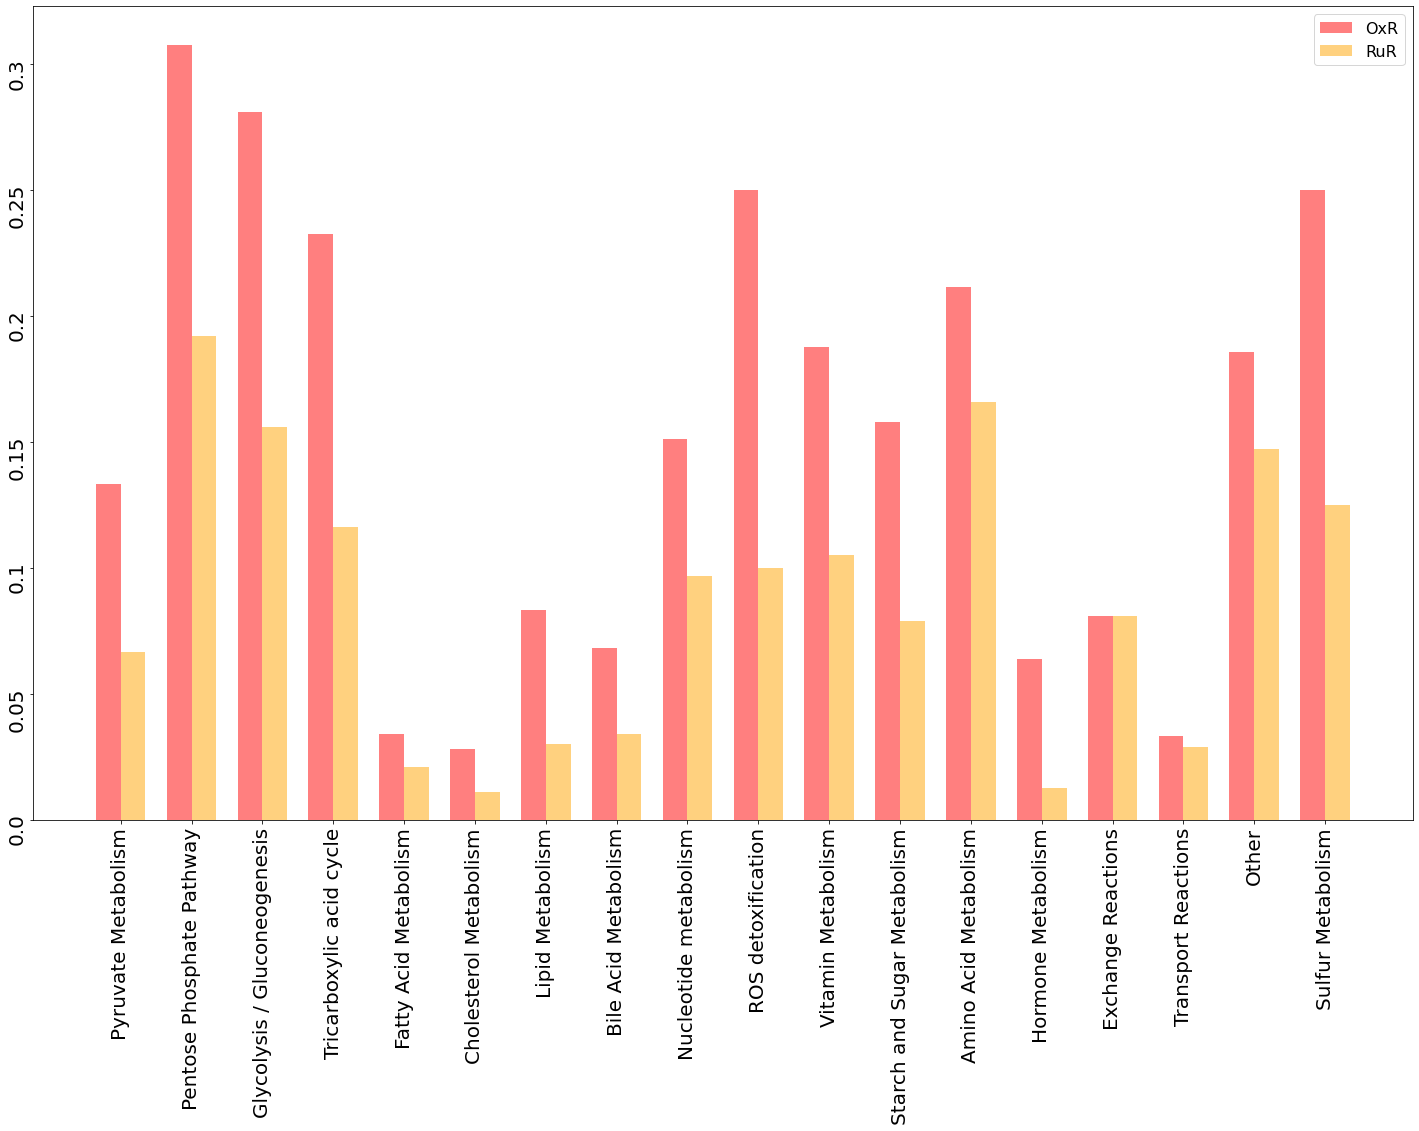

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

In [3]:
# Set up the plotting parameters 
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(20, 16))
width = 0.35
sgn = -1
p_diff = 0.15 # Use a 15% cutoff 

# Compare OxR resistance to its sensitive control and 
# RuR resistance to its sensitive control 
for c1,c2,col in [("Control","OxR","red"),("Control_DMSO","RuR","orange")]:
    
    all_names = [m.name for m in model.metabolites]
    metabo_dict = pickle.load(open("../Data/metabo_conc_abs.pkl","rb"))
    if p_diff >= 0.15:
        metabo_dict.pop('NADPH')
        metabo_dict.pop('ATP')
        metabo_dict.pop('GTP')
        metabo_dict.pop('NADP+')
        metabo_dict.pop('thymine')
        metabo_dict.pop('cAMP')
        metabo_dict.pop('dGTP')
        metabo_dict.pop('N-acetyl-L-aspartate')
    met_names = sorted(list(metabo_dict.keys()))
    
    # Gather subsystems of reactions that are different between 
    # the control and resistant cells 
    results_dict = Counter()
    for m in met_names:
        if m in all_names:
            met = model.metabolites[all_names.index(m)]
            # get subsystem of reactions associated with that metabolite 
            met_sub = np.unique([r.subsystem for r in met.reactions])
            x = metabo_dict[m][c1]
            y = metabo_dict[m][c2]
            if "nan" not in [str(i) for i in x] and "nan" not in [str(i) for i in y]:
                min_value = min(np.mean(x),np.mean(y))
                max_value = max(np.mean(x),np.mean(y))
                diff_val = (max_value - min_value)/max_value
                # Check percentage difference between control and non-control 
                if diff_val > p_diff:
                    counter_dict = Counter(met_sub)
                    results_dict = results_dict + counter_dict

    # Count all subsystems 
    pathway_cnt = Counter([r.subsystem for r in model.reactions])

    all_subsystems = set([r.subsystem for r in model.reactions])
    all_ratios = []
    all_names = []
    for sub_names in list(sub_manual.values()):
        full_names = []
        # Get all corresponding subsystems 
        for sub_name in sub_names:
            full_name = [s for s in all_subsystems if sub_name in s]
            full_names = full_names + full_name
        # Get key for value from dictionary
        name = list(sub_manual.keys())[list(sub_manual.values()).index(sub_names)] 
        # Get reactions associated with that set of subsystems 
        sub_rxns = [pathway_cnt[name] for name in full_names]
        # Get reactions associated with set of subsystems and in altered_rxns 
        associated_rxns = [results_dict[name] for name in full_names]
        sub_ratio = sum(associated_rxns)/sum(sub_rxns)
        if sub_ratio > 0.:
            all_ratios.append(sub_ratio)
            all_names.append(name)
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(20, 16))
    all_ratios = pd.Series(all_ratios)
    x = np.arange(len(all_names))
    ax.bar(x+sgn*width/2,all_ratios,width,label=c2,color=col,alpha=0.5)
    sgn = +1
ax.set_xticks(x)
ax.set_yticklabels([round(i,2) for i in np.arange(0,0.6,0.05)],rotation=90)
ax.set_xticklabels(all_names,rotation=90)
ax.legend()
fig.tight_layout()
fig.savefig("../Figures/Normalization/Barplot_RAW.svg")
plt.show()    

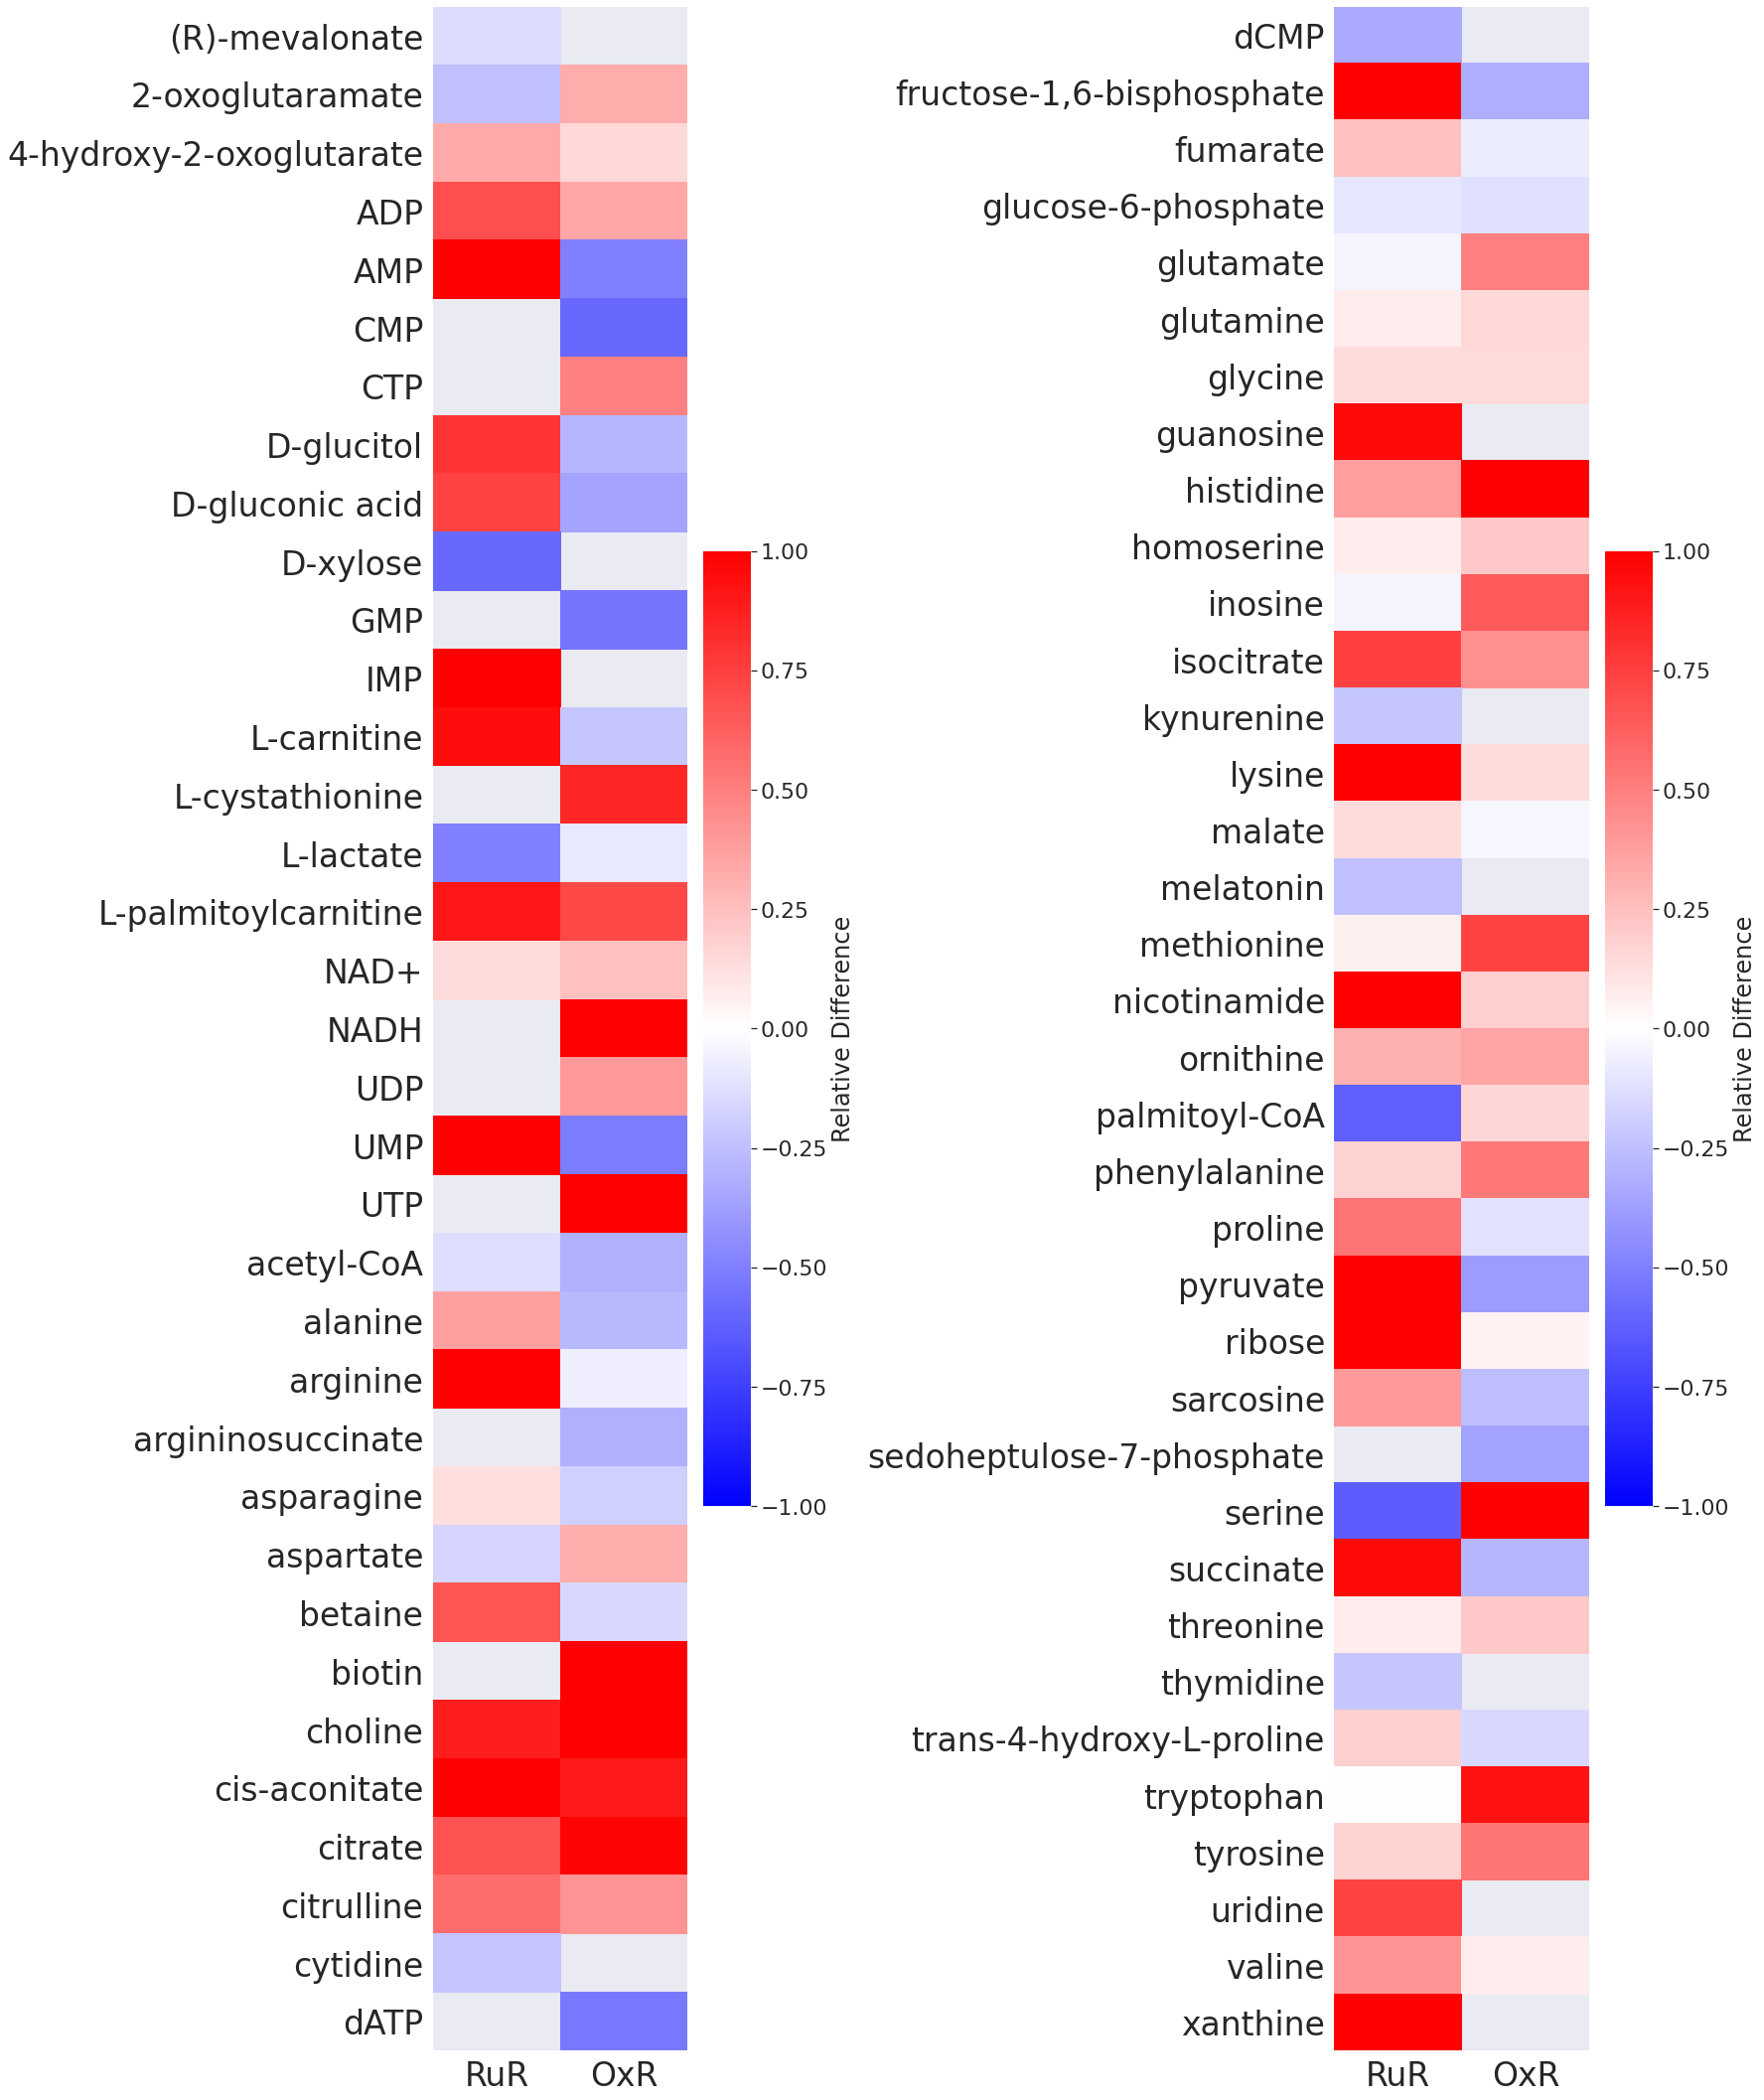

In [4]:
# Plot the raw data as a heatmap
sb.set(font_scale=3)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,30))

oxr_diff = []
rur_diff = []
met_ids = []
for met in met_names[:int(len(met_names)/2)]:
    oxr_relative = relative_flux(np.mean(metabo_dict[met]['OxR']),np.mean(metabo_dict[met]['Control']))
    rur_relative = relative_flux(np.mean(metabo_dict[met]['RuR']),np.mean(metabo_dict[met]['Control_DMSO']))
    oxr_diff.append(oxr_relative)
    rur_diff.append(rur_relative)
    met_ids.append(met)
    
data = {'RuR':rur_diff,'OxR':oxr_diff} 
df = pd.DataFrame(data,index = met_ids)
sb.set(font_scale=2)
heat_map = sb.heatmap(df,cmap='bwr',vmin=-1,vmax=+1,ax=ax1,cbar_kws={'label':'Relative Difference'})

oxr_diff = []
rur_diff = []
met_ids = []
for met in met_names[int(len(met_names)/2):]:
    oxr_relative = relative_flux(np.mean(metabo_dict[met]['OxR']),np.mean(metabo_dict[met]['Control']))
    rur_relative = relative_flux(np.mean(metabo_dict[met]['RuR']),np.mean(metabo_dict[met]['Control_DMSO']))
    oxr_diff.append(oxr_relative)
    rur_diff.append(rur_relative)
    met_ids.append(met)
    
data = {'RuR':rur_diff,'OxR':oxr_diff} 
df = pd.DataFrame(data,index = met_ids)
heat_map = sb.heatmap(df,cmap='bwr',vmin=-1,vmax=+1,
                      ax=ax2,cbar_kws={'label':'Relative Difference'})

plt.tight_layout()
plt.savefig("../Figures/Normalization/HeatmapRAW.svg",transparent=False)
plt.show()
# Not all metabolites were measured for all conditions, hence the NANs